In [12]:
!pip install pydicom
!pip install nilearn
import os
import pydicom
import nibabel as nib
from nibabel.affines import apply_affine
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import os
from nilearn import plotting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.0 MB/s eta 0:00:00


In [13]:
# Exploratory Metadata analysis of the .nii file
img = nib.load('/content/test1.nii')
data = img.get_fdata()
print(f"Image type: {type(img)}")
print(f"Image shape: {img.shape}")
print(f"Number of dimensions: {len(img.shape)}")

# Calculate total number of voxels
shape = img.shape
total_voxels = shape[0] * shape[1] * shape[2]
print(f"Total voxels: {total_voxels}")



Image type: <class 'nibabel.nifti1.Nifti1Image'>
Image shape: (256, 384, 384)
Number of dimensions: 3
Total voxels: 37748736


In [14]:
# An affine transformation matrix is a mathematical tool that maps coordinates from one space to another while preserving lines and parallelism.
# In neuroimaging, it's crucial for converting between voxel coordinates (array indices) and real-world millimeter coordinates in 3D space.
# When you lead an NIfTI image, the affine transformation matrix already stored in the file header and immediately accessible.
# The MRI scanner automatically calculates it on the basis of 1) image positioning 2) voxel size and 3) brain orientaiton
affine = img.affine
print(affine)
# To play with the affine transformation we would like to find an area of interest and then transform it into real-world coordinates
# Let us choose the brightest voxel in the given .nii file
peak_voxel = np.unravel_index(np.argmax(data), data.shape)
print(f"Peak activation at voxel: {peak_voxel}")

# 3. Convert to world coordinates for reporting
peak_world = apply_affine(affine, np.array([peak_voxel]))
print(f"Peak activation at: {peak_world[0]} mm")

# 4. Define a sphere around the peak
radius_mm = 5  # 5mm radius
center = peak_world[0]

def create_world_coordinates(img):
    """Create x, y, z coordinate arrays for each voxel"""
    shape = img.shape[:3]
    affine = img.affine
    i, j, k = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]
    voxel_coords = np.column_stack([i.ravel(), j.ravel(), k.ravel()])
    world_coords = apply_affine(affine, voxel_coords)
    x_coords = world_coords[:, 0].reshape(shape)
    y_coords = world_coords[:, 1].reshape(shape)
    z_coords = world_coords[:, 2].reshape(shape)

    return x_coords, y_coords, z_coords

# 5. Find all voxels within the 5mmm sphere range
x_coords, y_coords, z_coords = create_world_coordinates(img)
distances = np.sqrt((x_coords - center[0])**2 +
                   (y_coords - center[1])**2 +
                   (z_coords - center[2])**2)
sphere_mask = distances <= radius_mm

# 6. Extract values from the sphere
sphere_values = data[sphere_mask]
print(f"Mean value in {radius_mm}mm sphere: {sphere_values.mean():.3f}")

[[ 6.26228750e-01 -5.86845390e-02 -3.49271894e-02 -6.36599960e+01]
 [ 6.13057874e-02  6.20829523e-01  3.86882909e-02 -1.04477142e+02]
 [ 3.13100182e-02 -4.18554321e-02  6.22822821e-01 -1.21944519e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Peak activation at voxel: (np.int64(135), np.int64(187), np.int64(320))
Peak activation at: [-1.26982421 32.27451277 73.75867037] mm
Mean value in 5mm sphere: 2486.081


In [4]:
uploaded = files.upload()

# Extract the zip file
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print(f'Extracted {filename}')

print("\nLooking for SE folders:")
!ls -la /content/SE*


Saving dicom_series.zip to dicom_series.zip
Extracted dicom_series.zip

Looking for SE folders:
/content/SE000000:
total 708
drwxr-xr-x 2 root root   4096 May 31 05:36 .
drwxr-xr-x 1 root root   4096 May 31 05:36 ..
-rw-r--r-- 1 root root 140082 May 31 05:36 MR000000
-rw-r--r-- 1 root root 140154 May 31 05:36 MR000001
-rw-r--r-- 1 root root 140220 May 31 05:36 MR000002
-rw-r--r-- 1 root root 140218 May 31 05:36 MR000003
-rw-r--r-- 1 root root 140224 May 31 05:36 MR000004

/content/SE000001:
total 3788
drwxr-xr-x 2 root root   4096 May 31 05:36 .
drwxr-xr-x 1 root root   4096 May 31 05:36 ..
-rw-r--r-- 1 root root 139662 May 31 05:36 MR000000
-rw-r--r-- 1 root root 139734 May 31 05:36 MR000001
-rw-r--r-- 1 root root 139798 May 31 05:36 MR000002
-rw-r--r-- 1 root root 139798 May 31 05:36 MR000003
-rw-r--r-- 1 root root 139798 May 31 05:36 MR000004
-rw-r--r-- 1 root root 139798 May 31 05:36 MR000005
-rw-r--r-- 1 root root 139798 May 31 05:36 MR000006
-rw-r--r-- 1 root root 139798 May 31 0

In [5]:
# Reading the DICOM files, extracting images from the directories and reading the attached metadata

base_path = '/content/'
series_folders = ['SE000000', 'SE000001', 'SE000002']
metadata = {}

for series_name in series_folders:
    series_path = os.path.join(base_path, series_name)
    print(f"\nProcessing {series_name}...")

    all_files = os.listdir(series_path)
    print(f"Found {len(all_files)} files")
    print(f"Sample files: {all_files[:5]}")

    first_file_path = os.path.join(series_path, all_files[0])
    ds = pydicom.dcmread(first_file_path, force=True)
    print(f"Successfully read: {all_files[0]}")

    metadata[series_name] = {
        'PatientName': str(getattr(ds, 'PatientName', 'Unknown')),
        'StudyDate': getattr(ds, 'StudyDate', 'Unknown'),
        'Modality': getattr(ds, 'Modality', 'Unknown'),
        'SeriesDescription': getattr(ds, 'SeriesDescription', 'Unknown'),
        'PixelSpacing': getattr(ds, 'PixelSpacing', 'Unknown'),
        'SliceThickness': getattr(ds, 'SliceThickness', 'Unknown'),
        'ImagePositionPatient': getattr(ds, 'ImagePositionPatient', 'Unknown'),
        'Rows': getattr(ds, 'Rows', 'Unknown'),
        'Columns': getattr(ds, 'Columns', 'Unknown'),
        'NumberOfFiles': len(all_files)
    }

# Display the metadata
for series, info in metadata.items():
    print(f"\n{'='*50}")
    print(f"SERIES: {series}")
    print(f"{'='*50}")
    for key, value in info.items():
        print(f"{key:20}: {value}")



Processing SE000000...
Found 5 files
Sample files: ['MR000002', 'MR000003', 'MR000001', 'MR000000', 'MR000004']
Successfully read: MR000002

Processing SE000001...
Found 27 files
Sample files: ['MR000021', 'MR000017', 'MR000012', 'MR000011', 'MR000014']
Successfully read: MR000021

Processing SE000002...
Found 32 files
Sample files: ['MR000031', 'MR000030', 'MR000021', 'MR000017', 'MR000012']
Successfully read: MR000031

SERIES: SE000000
PatientName         : LIONHEART^WILLIAM
StudyDate           : 20150114
Modality            : MR
SeriesDescription   : Survey_MST
PixelSpacing        : [0.9765625, 0.9765625]
SliceThickness      : 10.0
ImagePositionPatient: [-15.578661166116, -142.16637217998, 104.620200037956]
Rows                : 256
Columns             : 256
NumberOfFiles       : 5

SERIES: SE000001
PatientName         : LIONHEART^WILLIAM
StudyDate           : 20150114
Modality            : MR
SeriesDescription   : T2W_TSE
PixelSpacing        : [0.9375, 0.9375]
SliceThickness      

In [41]:
def load_and_sort_series(series_path):
    dicom_files = []
    all_files = os.listdir(series_path)

    for filename in all_files:
        filepath = os.path.join(series_path, filename)
        ds = pydicom.dcmread(filepath, force=True)
        dicom_files.append(ds)

    print(f"Loaded {len(dicom_files)} DICOM files")

    #  Sorting by SliceLocation
    slices_with_location = []
    for ds in dicom_files:
        if hasattr(ds, 'SliceLocation'):
            slices_with_location.append(ds)

    print("Sorting by SliceLocation")
    sorted_slices = sorted(slices_with_location, key=lambda s: s.SliceLocation)

    # Display SliceLocation values in sorted order
    print("SliceLocation values in sorted order:")
    for i, s in enumerate(sorted_slices[:10]):  # Show first 10
        print(f"Slice {i}: {s.SliceLocation}")
    if len(sorted_slices) > 10:
        print(f"... and {len(sorted_slices) - 10} more slices")

    return sorted_slices

# Test with SE000000 series
series_path = '/content/SE000000'
sorted_slices = load_and_sort_series(series_path)

print(f"\nTotal sorted slices: {len(sorted_slices)}")
print(f"First slice position: {getattr(sorted_slices[0], 'SliceLocation', sorted_slices[0].ImagePositionPatient[2])}")
print(f"Last slice position: {getattr(sorted_slices[-1], 'SliceLocation', sorted_slices[-1].ImagePositionPatient[2])}")


Loaded 5 DICOM files
Sorting by SliceLocation
SliceLocation values in sorted order:
Slice 0: 0.0
Slice 1: 19.9999995267284
Slice 2: 39.9999990534569
Slice 3: 174.041300962232
Slice 4: 206.797699272813

Total sorted slices: 5
First slice position: 0.0
Last slice position: 206.797699272813


In [49]:
# Creating the 3d numpy array  by stacking sorted slices
def stack_slices_to_volume(sorted_slices):
    """Stack sorted DICOM slices into a 3D numpy array"""

    first_slice = sorted_slices[0]  # Fix: access first element, not the list
    rows = first_slice.Rows
    cols = first_slice.Columns
    num_slices = len(sorted_slices)

    print(f"Creating 3D volume with shape: ({rows}, {cols}, {num_slices})")

    volume_3d = np.zeros((rows, cols, num_slices), dtype=first_slice.pixel_array.dtype)

    for i, slice_ds in enumerate(sorted_slices):
        volume_3d[:, :, i] = slice_ds.pixel_array

    print(f"3D volume shape: {volume_3d.shape}")
    print(f"Data type: {volume_3d.dtype}")
    print(f"Min value: {volume_3d.min()}, Max value: {volume_3d.max()}")

    return volume_3d

In [50]:
# For the first series
series_path = '/content/SE000000'
sorted_slices = load_and_sort_series(series_path)

# Now stack the sorted slices into 3D volume
volume_3d = stack_slices_to_volume(sorted_slices)
print(volume_3d)

Loaded 5 DICOM files
Sorting by SliceLocation
SliceLocation values in sorted order:
Slice 0: 0.0
Slice 1: 19.9999995267284
Slice 2: 39.9999990534569
Slice 3: 174.041300962232
Slice 4: 206.797699272813
Creating 3D volume with shape: (256, 256, 5)
3D volume shape: (256, 256, 5)
Data type: uint16
Min value: 0, Max value: 263
[[[ 8 18 17  8 15]
  [12 24 13 10 13]
  [10 18  3  9  9]
  ...
  [ 5  8 11  8  2]
  [ 9  9  3  7  2]
  [ 5  3 10  3  7]]

 [[ 4  7  3 13  4]
  [13  5  9 12  7]
  [16  2  6  3 14]
  ...
  [ 2 12  5  8  3]
  [ 7  7 11  9  8]
  [ 5  3  9  7 11]]

 [[13  2 15 12  6]
  [18  3 16  9  0]
  [11  3  9  4  7]
  ...
  [ 8  4 18  8 13]
  [10  2 14  7 10]
  [ 6  0  6 12  6]]

 ...

 [[10  2  7  8 10]
  [10  4 10 14  8]
  [ 7 12  8  5  9]
  ...
  [24  5  5  4  5]
  [17  9  5 14  2]
  [ 3  5  9 11  2]]

 [[16  9 13  9  6]
  [13 12 21 10  5]
  [ 7  4 15  3  4]
  ...
  [10 12 10  7  8]
  [14 14 20  8  9]
  [16  4 15  1  7]]

 [[11  9 15 14  7]
  [ 9  9 10  5 15]
  [11  4  9  7 15]
  .

In [51]:
# Second series
series_path = '/content/SE000001'
sorted_slices = load_and_sort_series(series_path)

# Now stack the sorted slices into 3D volume
volume_3d = stack_slices_to_volume(sorted_slices)
print(volume_3d)

Loaded 27 DICOM files
Sorting by SliceLocation
SliceLocation values in sorted order:
Slice 0: 0.0
Slice 1: 5.99999663091323
Slice 2: 11.9999973042441
Slice 3: 17.9999979772582
Slice 4: 23.9999946081714
Slice 5: 29.9999952815023
Slice 6: 35.9999959546749
Slice 7: 41.9999963629367
Slice 8: 47.9999970362677
Slice 9: 53.9999958207213
... and 17 more slices
Creating 3D volume with shape: (256, 256, 27)
3D volume shape: (256, 256, 27)
Data type: uint16
Min value: 0, Max value: 805
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [

In [52]:
# For the third series
series_path = '/content/SE000002'
sorted_slices = load_and_sort_series(series_path)

# Now stack the sorted slices into 3D volume
volume_3d = stack_slices_to_volume(sorted_slices)
print(volume_3d)

Loaded 32 DICOM files
Sorting by SliceLocation
SliceLocation values in sorted order:
Slice 0: 0.0
Slice 1: 5.99999800806651
Slice 2: 12.0000035859053
Slice 3: 18.0000015939718
Slice 4: 23.9999996020383
Slice 5: 30.0000014180852
Slice 6: 36.0000032341321
Slice 7: 42.0000012462811
Slice 8: 48.0000030623280
Slice 9: 54.0000010703945
... and 22 more slices
Creating 3D volume with shape: (256, 256, 32)
3D volume shape: (256, 256, 32)
Data type: uint16
Min value: 0, Max value: 481
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [

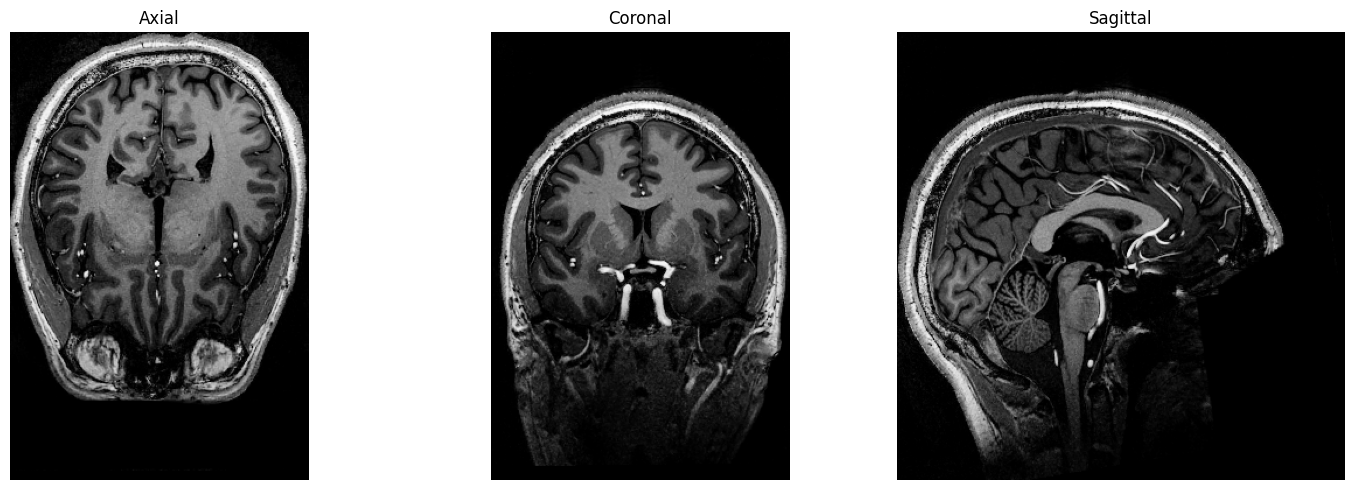

In [30]:
# Initially, I tried using nilearn with the plotting function but it was too computationally expensive, hence I switched to this manual version of slicing and printing


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Using the middle slices to get the most features
mid_x, mid_y, mid_z = data.shape[0]//2, data.shape[1]//2, data.shape[2]//2

# Axial (z-slice) - top-down view ; both left and right side of the brain are visible ; rotated orientation to allow easy viewing (also for the other two)
axial_rotated = np.rot90(data[:, :, mid_z], k=-1)
axes[0].imshow(axial_rotated, cmap='gray')
axes[0].set_title('Axial')
axes[0].axis('off')

# Coronal (y-slice) - vertical slice dividing the brain into posterior and anterior parts
coronal_rotated = np.rot90(data[:, mid_y, :], k=1)
axes[1].imshow(coronal_rotated, cmap='gray')
axes[1].set_title('Coronal')
axes[1].axis('off')

# Sagittal (x-slice) - vertical slice dividing the brain into let and right parts
sagittal_rotated = np.rot90(data[mid_x, :, :], k=1)
axes[2].imshow(sagittal_rotated, cmap='gray')
axes[2].set_title('Sagittal')
axes[2].axis('off')

plt.tight_layout()
plt.show()




In [35]:
from IPython.display import Markdown, display

markdown_content = """

## NIfTI RAS+ Convention

NIfTI follows RAS+ convention:

- **R (Right)**: X increases from left to right
- **A (Anterior)**: Y increases from posterior to anterior
- **S (Superior)**: Z increases from inferior to superior

## Multiple Affine Specifications

NIfTI can specify orientation in three ways:

1. **sform**: Scanner-based coordinates
2. **qform**: Quaternion-based orientation
3. **Fall-back**: Constructed from voxel sizes only

## Affine Matrix

NIfTI uses a 4x4 affine matrix to transform voxel indices to RAS+ world coordinates (as shown above).

## DICOM Patient-Based Coordinate System

DICOM uses a patient-based coordinate system:

- **X-axis**: Increases from right to left of the patient
- **Y-axis**: Increases from anterior to posterior (front to back)
- **Z-axis**: Increases from inferior to superior (feet to head)

## Image Orientation Patient (IOP) Tag

The DICOM tag  contains 6 values representing two 3D direction vectors.

## Image Position Patient (IPP)

This tag specifies the 3D coordinates of the upper-left corner (center of first voxel) of each slice.
"""

display(Markdown(markdown_content))




## NIfTI RAS+ Convention

NIfTI follows RAS+ convention:

- **R (Right)**: X increases from left to right
- **A (Anterior)**: Y increases from posterior to anterior  
- **S (Superior)**: Z increases from inferior to superior

## Multiple Affine Specifications

NIfTI can specify orientation in three ways:

1. **sform**: Scanner-based coordinates
2. **qform**: Quaternion-based orientation
3. **Fall-back**: Constructed from voxel sizes only

## Affine Matrix

NIfTI uses a 4x4 affine matrix to transform voxel indices to RAS+ world coordinates (as shown above).

## DICOM Patient-Based Coordinate System

DICOM uses a patient-based coordinate system:

- **X-axis**: Increases from right to left of the patient
- **Y-axis**: Increases from anterior to posterior (front to back)
- **Z-axis**: Increases from inferior to superior (feet to head)

## Image Orientation Patient (IOP) Tag

The DICOM tag  contains 6 values representing two 3D direction vectors.

## Image Position Patient (IPP)

This tag specifies the 3D coordinates of the upper-left corner (center of first voxel) of each slice.


In [39]:
from IPython.display import Markdown, display

markdown_content = """

## DICOM vs NIfTI Comparison Table

| **Aspect** | **DICOM** | **NIfTI** |
|------------|-----------|-----------|
| **Intended Use** | Clinical workflows, hospital systems, equipment interoperability | Research analysis, neuroimaging studies, data sharing |
| **File Structure** | Multiple 2D slice files per scan (dozens to hundreds) | Single 3D volume file (.nii or .nii.gz) |
| **Metadata** | Comprehensive metadata with patient info, equipment settings, clinical notes | Minimal essential metadata, strips away clinical details |
| **Interoperability** | Universal medical standard across manufacturers | Research-focused, better for analysis tools |
| **Privacy** | Contains patient demographics and clinical data | Anonymized, suitable for data sharing |
| **Conversion** | Source format from medical equipment | Target format requiring conversion step |
| **Best For** | Clinical diagnosis, archiving, regulatory compliance | Machine learning, statistical analysis, visualization |

"""

display(Markdown(markdown_content))






## DICOM vs NIfTI Comparison Table

| **Aspect** | **DICOM** | **NIfTI** |
|------------|-----------|-----------|
| **Intended Use** | Clinical workflows, hospital systems, equipment interoperability | Research analysis, neuroimaging studies, data sharing |
| **File Structure** | Multiple 2D slice files per scan (dozens to hundreds) | Single 3D volume file (.nii or .nii.gz) |
| **Metadata** | Comprehensive metadata with patient info, equipment settings, clinical notes | Minimal essential metadata, strips away clinical details |
| **Interoperability** | Universal medical standard across manufacturers | Research-focused, better for analysis tools |
| **Privacy** | Contains patient demographics and clinical data | Anonymized, suitable for data sharing |
| **Conversion** | Source format from medical equipment | Target format requiring conversion step |
| **Best For** | Clinical diagnosis, archiving, regulatory compliance | Machine learning, statistical analysis, visualization |

